# Tau_hmu regressor final training

## Import

### Import modules

In [1]:
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from rep.estimators import XGBoostClassifier
import root_numpy
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras import backend as K
from __future__ import division
import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import sys
sys.path.append('../')
from MPPlot import *

Couldn't import dot_parser, loading of dot files will not be possible.


/home/giles/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Welcome to ROOTaaS 6.06/04


/home/giles/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/root_numpy/__init__.py:35: RuntimeWarning: numpy 1.13.0 is currently installed but you installed root_numpy against numpy 1.11.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using Theano backend.


### Import data
Here just looking at mu tau_h b b final-state

In [2]:
mode = "mu_tau_b_b"
dataVersion = "v1"
signalData = pandas.DataFrame(root_numpy.root2array("/home/giles/cernbox/sample_analysis/MG5_pp_hh_bbtt_13TeV_10M_py8_" + dataVersion + ".root", treename = mode))
backgroundData = pandas.DataFrame(root_numpy.root2array("/home/giles/cernbox/sample_analysis/PH_pp_tt_ll_13Tev_10M_py8_" + "v1" + ".root", treename = mode))
print "Samples contains", len(signalData), "signal events and", len(backgroundData), "background events"
print len(signalData)+len(backgroundData), "events in total"

Samples contains 71614 signal events and 103690 background events
175304 events in total


## Configure data

### Add classification targets and combine into single dataset

In [3]:
signalData["gen_target"] = 1
backgroundData["gen_target"] = 0
data = signalData.append(backgroundData, ignore_index = True)

### Create development and validation samples

In [4]:
sig_devIndeces, sig_valIndeces = train_test_split([i 
                                                   for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                                  test_size=0.2, random_state=1337)
bkg_devIndeces, bkg_valIndeces = train_test_split([i for i in data[(data.gen_target == 0) & (data.gen_mctMatch == 0)].index.tolist()],
                                                  test_size=0.2, random_state=1337)

### Move to cartesian coordinates

In [5]:
def moveToCartesian(inData, particle, z = True):
    pt = inData.ix[:, particle + "_pT"]
    if z: eta = inData.ix[:, particle + "_eta"]
    phi = inData.ix[:, particle + "_phi"]
    inData[particle + '_px'] = pt*np.cos(phi)
    inData[particle + '_py'] = pt*np.sin(phi)
    if z: inData[particle + '_pz'] = pt*np.sinh(eta)

In [6]:
moveToCartesian(data, 'gen_t_0')
moveToCartesian(data, 'gen_t_1')
moveToCartesian(data, 'gen_b_0')
moveToCartesian(data, 'gen_b_1')
moveToCartesian(data, 't_0')
moveToCartesian(data, 't_1')
moveToCartesian(data, 'b_0')
moveToCartesian(data, 'b_1')
moveToCartesian(data, 'h_tt')
moveToCartesian(data, 'h_bb')
moveToCartesian(data, 'diH')
moveToCartesian(data, 'mPT', False)

### High-level variables

In [7]:
def deltaphi(a, b):
    return math.pi-np.abs(np.abs(a-b)-math.pi)

In [8]:
finalStates = ['b_0', 'b_1', 't_0', 't_1']
recoObjects = ['diH', 'h_bb', 'h_tt']
variables = ['px', 'py', 'pz']
for fs1 in finalStates:
    for fs2 in finalStates:
        if fs1 == fs2: continue
        for var in variables:
            data['hl_d' + var + '_' + fs1 + '_' + fs2] = data.ix[:, fs1 + '_' + var] - data.ix[:, fs2 + '_' + var]
    data['hl_dpx_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_px'] - data.ix[:, 'mPT_px']
    data['hl_dpy_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_py'] - data.ix[:, 'mPT_py']
    data[fs1 + '_|p|'] = np.sqrt(np.square(data.ix[:, fs1 + '_px'])+np.square(data.ix[:, fs1 + '_py'])+np.square(data.ix[:, fs1 + '_pz']))
    data[fs1 + '_E'] = np.sqrt(np.square(data.ix[:, fs1 + '_mass'])+np.square(data.ix[:, fs1 + '_|p|']))
for fs1 in recoObjects:
    for fs2 in recoObjects:
        if fs1 == fs2: continue
        for var in variables:
            data['hl_d' + var + '_' + fs1 + '_' + fs2] = data.ix[:, fs1 + '_' + var] - data.ix[:, fs2 + '_' + var]
    data['hl_dpx_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_px'] - data.ix[:, 'mPT_px']
    data['hl_dpy_' + fs1 + '_mPT'] = data.ix[:, fs1 + '_py'] - data.ix[:, 'mPT_py']
    data[fs1 + '_|p|'] = np.sqrt(np.square(data.ix[:, fs1 + '_px'])+np.square(data.ix[:, fs1 + '_py'])+np.square(data.ix[:, fs1 + '_pz']))
    data[fs1 + '_E'] = np.sqrt(np.square(data.ix[:, fs1 + '_mass'])+np.square(data.ix[:, fs1 + '_|p|']))
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

### Specify variables

In [9]:
data.rename(columns={'weight': 'gen_weight'}, inplace=True)
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]

In [10]:
globalKinFeatures = [var for var in trainFeatures if (str.startswith(var, "min")) or (str.startswith(var, "mean")) or (str.startswith(var, "max"))] + ['hT', 'sT', 'eVis']
globalMultiFeatures = [var for var in trainFeatures if (str.startswith(var, "n"))]
globalShapeFeatures = ['centrality', 'sphericityA', 'spherocityA', 'aplanarityA', 'aplanorityA', 'upsilonA', 'dShapeA']
primaryShapeFeatures = ['sphericityP', 'spherocityP', 'aplanarityP', 'aplanorityP', 'upsilonP', 'dShapeP']
globalFeatures = globalKinFeatures + globalMultiFeatures + globalShapeFeatures
shapeFeatures = globalShapeFeatures + primaryShapeFeatures
pTEtaPhi = [var for var in trainFeatures if (str.endswith(var, "_pT")) or (str.endswith(var, "_phi")) or (str.endswith(var, "_eta"))]
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_")) or (var == "mT")]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in globalFeatures + shapeFeatures + pTEtaPhi + hlFeatures + recoFeatures]

In [11]:
regTrainFeatures_tauH = ['t_0_mass', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E',
        'mPT_px', 'mPT_py',
        'h_tt_E',
        'b_0_mass', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E',
        'b_1_mass', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E',
        'hl_mT',
        'h_bb_mass', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E',
        'diH_E', 'diH_|p|', 'diH_mass']
regTrainFeatures_tauMu = ['t_1_mass', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E',
        'mPT_px', 'mPT_py',
        'h_tt_E',
        'b_0_mass', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E',
        'b_1_mass', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E',
        'hl_mT',
        'h_bb_mass', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E',
        'diH_E', 'diH_|p|', 'diH_mass']
regTargetFeatures_tauH = ['gen_t_0_px', 'gen_t_0_py', 'gen_t_0_pz']
regTargetFeatures_tauMu = ['gen_t_1_px', 'gen_t_1_py', 'gen_t_1_pz']

In [12]:
devData = data.loc[sig_devIndeces].copy()
devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data.loc[bkg_valIndeces].copy(), ignore_index = True)
#valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
#sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)
print "{0} events for training, {1} events for validation".format(len(devData), len(valData))

132076 events for training, 33019 events for validation


## Load regressors

In [13]:
name = "weights/NN_Tauh_Regressor_SO_App_" + mode + "_" + dataVersion
ensembleSize = 10
tauH_ensemble = []
tauH_weights = None
tauH_inputPipe = None
tauH_outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    tauH_ensemble.append(model)
with open(name + '_weights.pkl', 'r') as fin:
    tauH_weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'r') as fin:
    tauH_inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'r') as fin:
    tauH_outputPipe = pickle.load(fin)

/home/giles/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/giles/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator PCA from version 0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/giles/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [14]:
name = "weights/NN_Taumu_Regressor_SO_App_" + mode + "_" + dataVersion
ensembleSize= 10
tauMu_ensemble = []
tauMu_weights = None
tauMu_inputPipe = None
tauMu_outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    tauMu_ensemble.append(model)
with open(name + '_weights.pkl', 'r') as fin:
    tauMu_weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'r') as fin:
    tauMu_inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'r') as fin:
    tauMu_outputPipe = pickle.load(fin)

## Response of ensemble on development data

###  Preprocess data

In [15]:
X_dev_tauH = tauH_inputPipe.transform(devData[regTrainFeatures_tauH].values.astype(theano.config.floatX))
X_dev_tauMu = tauMu_inputPipe.transform(devData[regTrainFeatures_tauMu].values.astype(theano.config.floatX))

### Get response

In [16]:
pred_tauH = np.zeros((len(devData), len(regTargetFeatures_tauH)))
for i, model in enumerate(tauH_ensemble):
    pred_tauH += tauH_weights[i]*tauH_outputPipe.inverse_transform(model.predict(X_dev_tauH, verbose=0))
pred_tauMu = np.zeros((len(devData), len(regTargetFeatures_tauMu)))
for i, model in enumerate(tauMu_ensemble):
    pred_tauMu += tauMu_weights[i]*tauMu_outputPipe.inverse_transform(model.predict(X_dev_tauMu, verbose=0))

In [17]:
for n, feature in enumerate(regTargetFeatures_tauH):
    devData['reg_' + feature[4:]] = pandas.Series(pred_tauH[:,n], index=devData.index)
for n, feature in enumerate(regTargetFeatures_tauMu):
    devData['reg_' + feature[4:]] = pandas.Series(pred_tauMu[:,n], index=devData.index)
tauMass = 1.77686
devData['reg_t_0_|p|'] = np.sqrt(np.square(devData.ix[:,'reg_t_0_px'])+np.square(devData.ix[:,'reg_t_0_py'])+np.square(devData.ix[:,'reg_t_0_pz']))
devData['reg_t_1_|p|'] = np.sqrt(np.square(devData.ix[:,'reg_t_1_px'])+np.square(devData.ix[:,'reg_t_1_py'])+np.square(devData.ix[:,'reg_t_1_pz']))
devData['reg_t_0_E'] = np.sqrt((tauMass**2)+np.square(devData.ix[:,'reg_t_0_px'])+np.square(devData.ix[:,'reg_t_0_py'])+np.square(devData.ix[:,'reg_t_0_pz']))
devData['reg_t_1_E'] = np.sqrt((tauMass**2)+np.square(devData.ix[:,'reg_t_1_px'])+np.square(devData.ix[:,'reg_t_1_py'])+np.square(devData.ix[:,'reg_t_1_pz']))
devData['reg_h_tt_px'] = devData.ix[:,'reg_t_1_px']+devData.ix[:,'reg_t_0_px']
devData['reg_h_tt_py'] = devData.ix[:,'reg_t_1_py']+devData.ix[:,'reg_t_0_py']
devData['reg_h_tt_pz'] = devData.ix[:,'reg_t_1_pz']+devData.ix[:,'reg_t_0_pz']
devData['reg_h_tt_E'] = devData.ix[:,'reg_t_1_E']+devData.ix[:,'reg_t_0_E']
devData['reg_h_tt_|p|'] = np.sqrt(np.square(devData.ix[:,'reg_h_tt_px'])+np.square(devData.ix[:,'reg_h_tt_py'])+np.square(devData.ix[:,'reg_h_tt_pz']))
devData['reg_h_tt_mass'] = np.sqrt(np.square(devData.ix[:,'reg_h_tt_E'])-np.square(devData.ix[:,'reg_h_tt_|p|']))

### Evaluate response

In [18]:
devData['loss_d'] = 0
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    devData.ix[:, 'loss_d'] += np.square(devData.ix[devData.gen_target == 1, 'reg_' + feature[4:]]-devData.ix[:, feature])
boot = mpRun([{'data':devData[devData.gen_target == 1]['reg_h_tt_mass'].values, 'mean':1, 'std':1}])
meanReg = (np.mean(boot['_mean']), np.std(boot['_mean'])/math.sqrt(len(boot['_mean'])))
stdevReg = (np.mean(boot['_std']), np.std(boot['_std'])/math.sqrt(len(boot['_std'])))
print 'Ensemble on dev data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(devData.ix[:, 'loss_d'])/len(regTargetFeatures_tauH + regTargetFeatures_tauMu), meanReg[0], meanReg[1], stdevReg[0], stdevReg[1])

Ensemble on dev data:
 Loss = 244.064609738, Mean = 126.932064803 +- 0.00658305503899, sigma = 14.6142122869 +- 0.00754595837716


## Response of ensemble on validation data

###  Preprocess data

In [16]:
X_val_tauH = tauH_inputPipe.transform(valData[regTrainFeatures_tauH].values.astype(theano.config.floatX))
X_val_tauMu = tauMu_inputPipe.transform(valData[regTrainFeatures_tauMu].values.astype(theano.config.floatX))

### Get response

In [17]:
pred_tauH = np.zeros((len(valData), len(regTargetFeatures_tauH)))
for i, model in enumerate(tauH_ensemble):
    pred_tauH += tauH_weights[i]*tauH_outputPipe.inverse_transform(model.predict(X_val_tauH, verbose=0))
pred_tauMu = np.zeros((len(valData), len(regTargetFeatures_tauMu)))
for i, model in enumerate(tauMu_ensemble):
    pred_tauMu += tauMu_weights[i]*tauMu_outputPipe.inverse_transform(model.predict(X_val_tauMu, verbose=0))

In [18]:
for n, feature in enumerate(regTargetFeatures_tauH):
    valData['reg_' + feature[4:]] = pandas.Series(pred_tauH[:,n], index=valData.index)
for n, feature in enumerate(regTargetFeatures_tauMu):
    valData['reg_' + feature[4:]] = pandas.Series(pred_tauMu[:,n], index=valData.index)
tauMass = 1.77686
valData['reg_t_0_|p|'] = np.sqrt(np.square(valData.ix[:,'reg_t_0_px'])+np.square(valData.ix[:,'reg_t_0_py'])+np.square(valData.ix[:,'reg_t_0_pz']))
valData['reg_t_1_|p|'] = np.sqrt(np.square(valData.ix[:,'reg_t_1_px'])+np.square(valData.ix[:,'reg_t_1_py'])+np.square(valData.ix[:,'reg_t_1_pz']))
valData['reg_t_0_E'] = np.sqrt((tauMass**2)+np.square(valData.ix[:,'reg_t_0_px'])+np.square(valData.ix[:,'reg_t_0_py'])+np.square(valData.ix[:,'reg_t_0_pz']))
valData['reg_t_1_E'] = np.sqrt((tauMass**2)+np.square(valData.ix[:,'reg_t_1_px'])+np.square(valData.ix[:,'reg_t_1_py'])+np.square(valData.ix[:,'reg_t_1_pz']))
valData['reg_h_tt_px'] = valData.ix[:,'reg_t_1_px']+valData.ix[:,'reg_t_0_px']
valData['reg_h_tt_py'] = valData.ix[:,'reg_t_1_py']+valData.ix[:,'reg_t_0_py']
valData['reg_h_tt_pz'] = valData.ix[:,'reg_t_1_pz']+valData.ix[:,'reg_t_0_pz']
valData['reg_h_tt_E'] = valData.ix[:,'reg_t_1_E']+valData.ix[:,'reg_t_0_E']
valData['reg_h_tt_|p|'] = np.sqrt(np.square(valData.ix[:,'reg_h_tt_px'])+np.square(valData.ix[:,'reg_h_tt_py'])+np.square(valData.ix[:,'reg_h_tt_pz']))
valData['reg_h_tt_mass'] = np.sqrt(np.square(valData.ix[:,'reg_h_tt_E'])-np.square(valData.ix[:,'reg_h_tt_|p|']))

### Evaluate response

In [19]:
valData['loss_v'] = 0
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    valData.ix[sig, 'loss_v'] += np.square(valData.ix[sig, 'reg_' + feature[4:]]-valData.ix[sig, feature])
boot = mpRun([{'data':valData[sig]['reg_h_tt_mass'].values, 'mean':1, 'std':1}])
meanReg = (np.mean(boot['_mean']), np.std(boot['_mean'])/math.sqrt(len(boot['_mean'])))
stdReg = (np.mean(boot['_std']), np.std(boot['_std'])/math.sqrt(len(boot['_std'])))
print 'Ensemble on val data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(valData.ix[sig, 'loss_v'])/len(regTargetFeatures_tauH + regTargetFeatures_tauMu), meanReg[0], meanReg[1], stdReg[0], stdReg[1])

Ensemble on val data:
 Loss = 422.384081989, Mean = 126.80126109 +- 0.0174022851671, sigma = 17.1560857378 +- 0.0329834795431


### Momentum distributions

In [23]:
pltArgs = []
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sig, feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1},
              {'data':valData.ix[sig, feature[4:]], 'x':xPlot, 'name':'rec_' + feature, 'kde':1},
              {'data':valData.ix[sig, "reg_" + feature[4:]], 'x':xPlot, 'name':'reg_' + feature, 'kde':1}]
plots = mpRun(pltArgs)

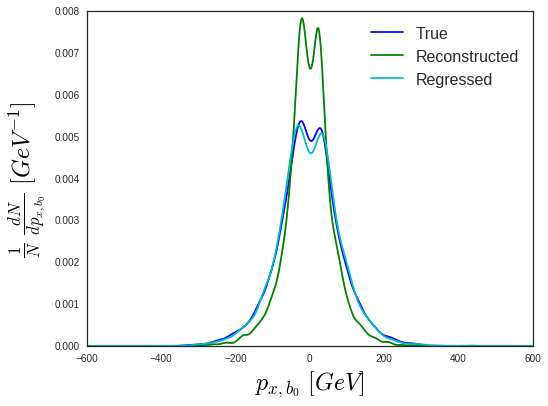

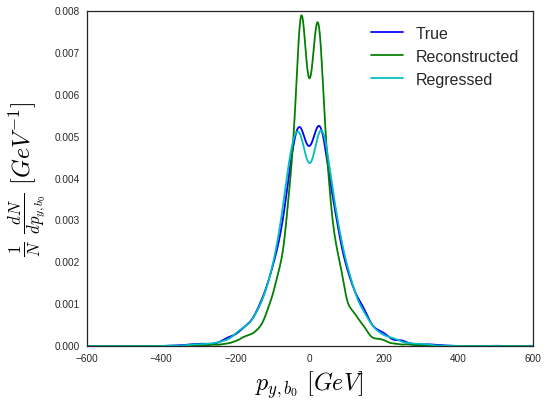

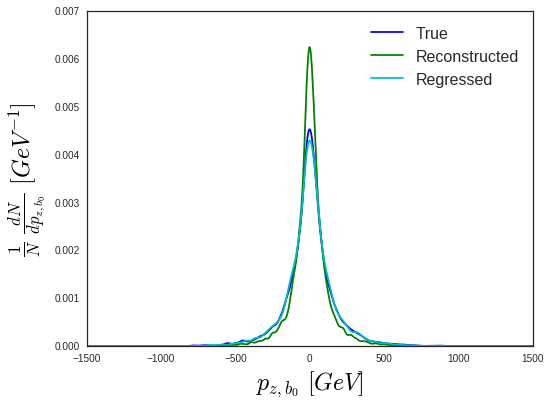

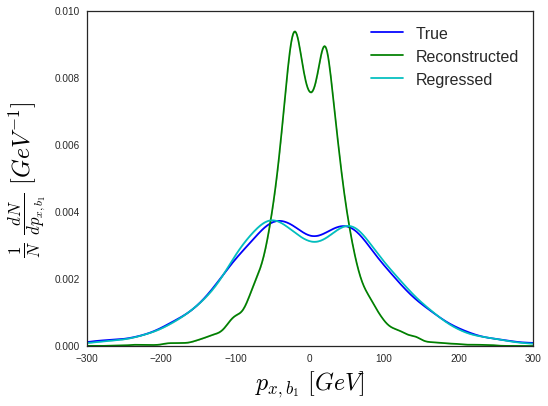

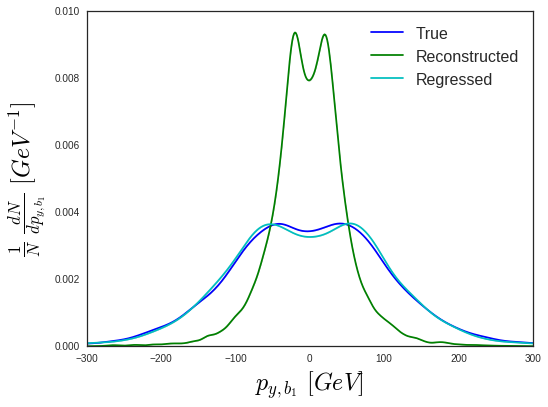

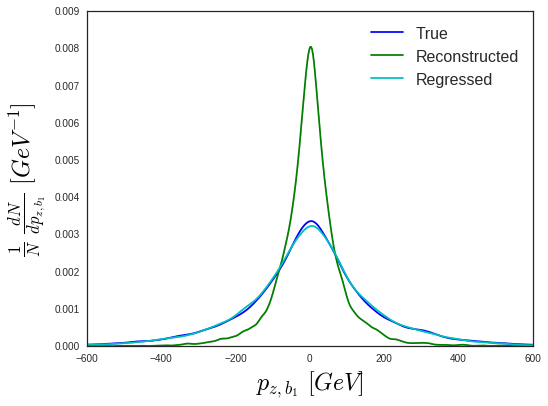

In [24]:
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    if '_1_' in feature:
        xPlot = np.linspace(-300, 300, 500)[:, np.newaxis]
        if 'pz' in feature:
            xPlot = np.linspace(-600, 600, 500)[:, np.newaxis]
    plt.figure(figsize=(8, 6))    
    sns.tsplot(data=plots['gen_' + feature + '_kde'], time=xPlot, condition='True', color='b')
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot, condition='Reconstructed', color='g')
    sns.tsplot(data=plots['reg_' + feature + '_kde'], time=xPlot, condition='Regressed', color='c')
    plt.legend(fontsize=16)
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Momentum pull distributions

In [25]:
pltArgs = []
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    pltArgs += [{'data':valData.ix[sig, feature[4:]]-valData.ix[sig, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sig, 'reg_' + feature[4:]]-valData.ix[sig, feature], 'x':xPlot, 'name':'reg_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)

Reco:	t_0_px	0.495866004812 +- 0.0336221309548	35.4215090719 +- 0.0695914344049
Reg:	t_0_px	0.0561138794269 +- 0.0124404581424	14.0169581428 +- 0.0229982470027
Reco:	t_0_py	-0.0368123972597 +- 0.0310905252822	35.5691425828 +- 0.0534288969393
Reg:	t_0_py	-0.353099398964 +- 0.0145366785937	13.8089804555 +- 0.022596583281
Reco:	t_0_pz	0.0633200712202 +- 0.0624035313284	69.572354405 +- 0.135808482431
Reg:	t_0_pz	0.15368928536 +- 0.0270861169743	27.6584447887 +- 0.0700140921068
Reco:	t_1_px	0.93842964259 +- 0.0621680599703	65.5614490179 +- 0.0706054997877
Reg:	t_1_px	0.389898404095 +- 0.0120589886016	16.1180307328 +- 0.0232520819196
Reco:	t_1_py	0.420690988867 +- 0.0531872546364	63.9099090823 +- 0.0589183228806
Reg:	t_1_py	-0.257360033404 +- 0.0164046700002	16.1525056394 +- 0.0201660750467
Reco:	t_1_pz	-1.02601249958 +- 0.0889925188228	113.003995353 +- 0.131346407575
Reg:	t_1_pz	0.0872361098939 +- 0.0250641935835	29.2099264541 +- 0.0581287413996


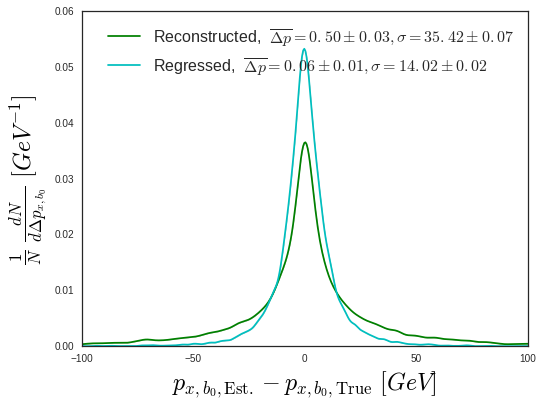

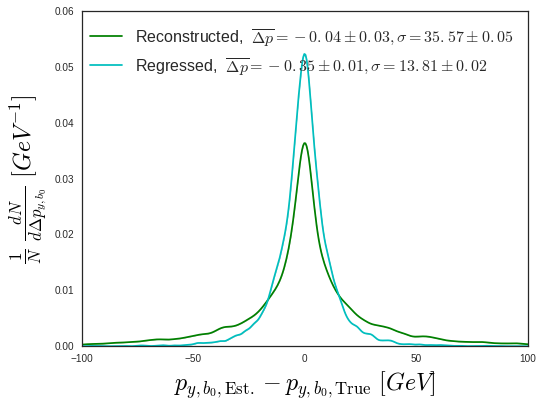

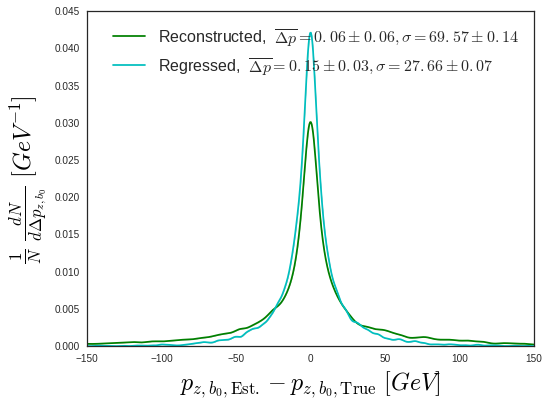

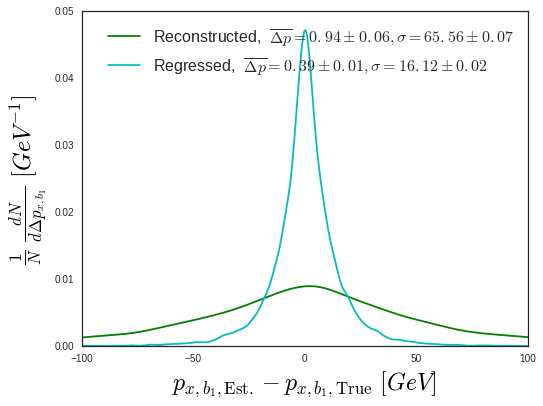

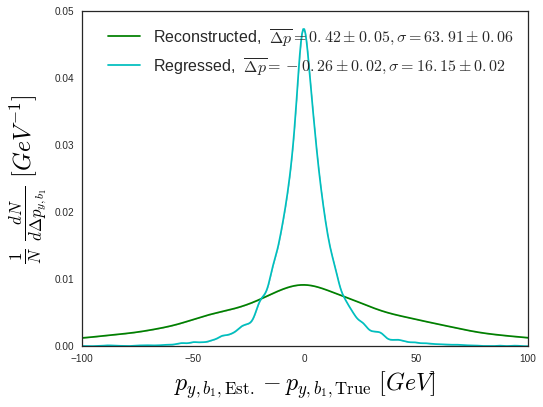

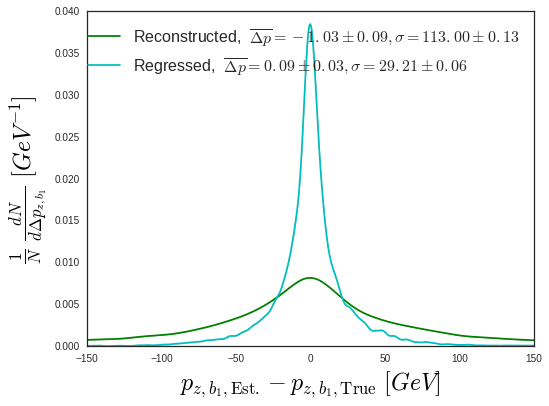

In [26]:
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['rec_' + feature + '_kde'], time=xPlot,
               condition=r'Reconstructed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='g')
    mean = (np.mean(plots['reg_' + feature + '_mean']),
            np.std(plots['reg_' + feature + '_mean'])/math.sqrt(len(plots['reg_' + feature + '_mean'])))
    stdev = (np.mean(plots['reg_' + feature + '_std']),
             np.std(plots['reg_' + feature + '_std'])/math.sqrt(len(plots['reg_' + feature + '_std'])))
    print "Reg:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.tsplot(data=plots['reg_' + feature + '_kde'], time=xPlot,
               condition=r'Regressed,  $\overline{\Delta p}' + r'= {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(mean[0], mean[1], stdev[0], stdev[1]),
               color='c')
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Two-sample Kolmogorov–Smirnov test

In [27]:
for n, feature in enumerate(regTargetFeatures_tauH + regTargetFeatures_tauMu):
    print 
    print feature
    ksTest = ks_2samp(valData[sig][feature].values, valData[sig]['reg_' + feature[4:]].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])


gen_t_0_px
K-S test result 0.0139, p-value of 0.1834

gen_t_0_py
K-S test result 0.0142, p-value of 0.1638

gen_t_0_pz
K-S test result 0.0099, p-value of 0.5882

gen_t_1_px
K-S test result 0.0103, p-value of 0.5357

gen_t_1_py
K-S test result 0.0112, p-value of 0.4274

gen_t_1_pz
K-S test result 0.0084, p-value of 0.7792


### Higgs mass distribution

In [28]:
xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[sig, 'reg_h_tt_mass'], 'name':'reg', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':valData.ix[sig, 'h_tt_mass'], 'name':'rec', 'x':xPlot, 'kde':1, 'mean':1, 'std':1}])
meanReg = (np.mean(plots['reg_mean']), np.std(plots['reg_mean'])/math.sqrt(len((plots['reg_mean']))))
stdReg = (np.mean(plots['reg_std']), np.std(plots['reg_std'])/math.sqrt(len(plots['reg_std'])))
meanReco = (np.mean(plots['rec_mean']), np.std(plots['rec_mean'])/math.sqrt(len((plots['rec_mean']))))
stdReco = (np.mean(plots['rec_std']), np.std(plots['rec_std'])/math.sqrt(len(plots['rec_std'])))
print "Distribution\t\tmean\tsigma"
print 'Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdReg[0], stdReg[1])
print 'Reconstructed Signal,  Mean = {:} +- {:}, sigma = {:} +- {:}'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1])

Distribution		mean	sigma
Regressed Signal, Mean = 126.826913333 +- 0.0135373386094, sigma = 17.1352911977 +- 0.0336276396898
Reconstructed Signal,  Mean = 144.687096129 +- 0.0486354164427, sigma = 57.2104952709 +- 0.0836214593593


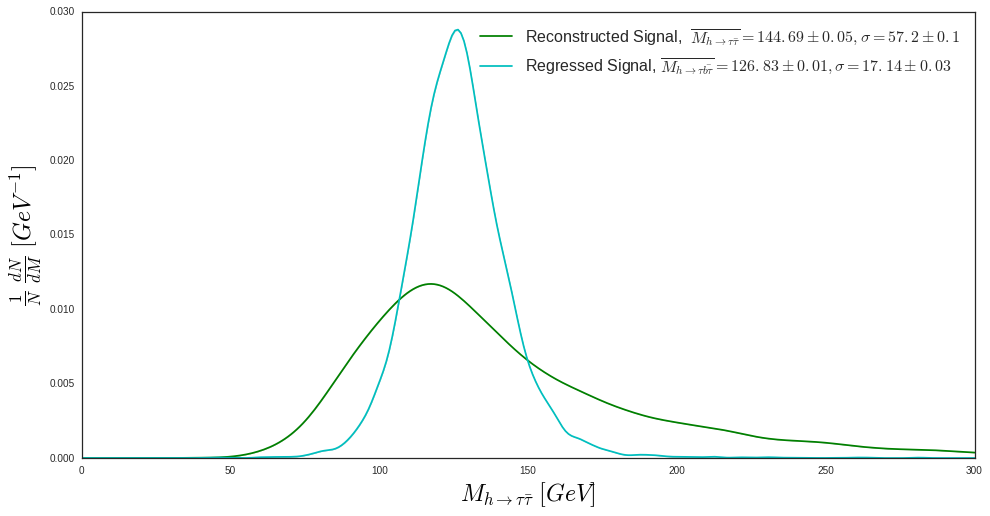

In [29]:
hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec_kde'], time=xPlot, 
          condition=r'Reconstructed Signal,  $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.1f}\pm{:.1f}$'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),
          color='g')
sns.tsplot(data=plots['reg_kde'], time=xPlot, 
          condition=r'Regressed Signal, $\overline{M_{h\rightarrow \tau\bar{b\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanReg[0], meanReg[1], stdReg[0], stdReg[1]),
          color='c')
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow \tau\bar{\tau}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [30]:
xPlot = np.linspace(-0.5, 0.5, 500)[:, np.newaxis]
plots = mpRun([{'data':(valData.ix[sig, 'reg_h_tt_mass']-125)/125, 'name':'reg', 'x':xPlot, 'kde':1, 'mean':1, 'std':1},
              {'data':(valData.ix[sig, 'h_tt_mass']-125)/125, 'name':'rec', 'x':xPlot, 'kde':1, 'mean':1, 'std':1}])
meanReg = (np.mean(plots['reg_mean']), np.std(plots['reg_mean'])/math.sqrt(len((plots['reg_mean']))))
stdReg = (np.mean(plots['reg_std']), np.std(plots['reg_std'])/math.sqrt(len(plots['reg_std'])))
meanReco = (np.mean(plots['rec_mean']), np.std(plots['rec_mean'])/math.sqrt(len((plots['rec_mean']))))
stdReco = (np.mean(plots['rec_std']), np.std(plots['rec_std'])/math.sqrt(len(plots['rec_std'])))
print "Distribution\t\tmean\tsigma"
print 'Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdReg[0], stdReg[1])
print 'Reconstructed Signal,  Mean = {:} +- {:}, sigma = {:} +- {:}'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1])

Distribution		mean	sigma
Regressed Signal, Mean = 0.0146153066652 +- 0.000108298708875, sigma = 0.137082329581 +- 0.000269021117518
Reconstructed Signal,  Mean = 0.157496769033 +- 0.000389083331542, sigma = 0.457683962167 +- 0.000668971674874


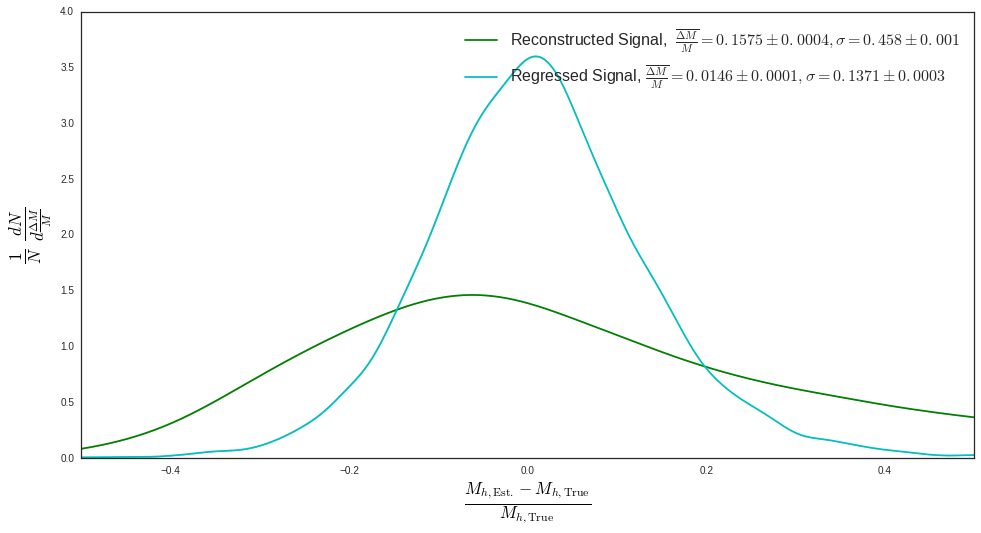

In [31]:
hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['rec_kde'], time=xPlot,
          condition=r'Reconstructed Signal,  $\overline{\frac{\Delta M}{M}}' + r' = {:.4f}\pm{:.4f}, \sigma = {:.3f}\pm{:.3f}$'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]),
          color='g')
sns.tsplot(data=plots['reg_kde'], time=xPlot, 
          condition=r'Regressed Signal, $\overline{\frac{\Delta M}{M}}' + r' = {:.4f}\pm{:.4f}, \sigma = {:.4f}\pm{:.4f}$'.format(meanReg[0], meanReg[1], stdReg[0], stdReg[1]),
          color='c')
plt.legend(fontsize=16)
plt.xlabel(r"$\frac{M_{h,\mathrm{Est.}}-M_{h,\mathrm{True}}}{M_{h,\mathrm{True}}}$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\frac{\Delta M}{M}}$", fontsize=24, color='black')
plt.show()

In [21]:
xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[bkg, 'h_tt_mass'], 'x':xPlot, 'name':'bkg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[bkg, 'reg_h_tt_mass'], 'x':xPlot, 'name':'bkg_reg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sig, 'h_tt_mass'], 'x':xPlot, 'name':'sig', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sig, 'reg_h_tt_mass'], 'x':xPlot, 'name':'sig_reg', 'kde':1, 'mean':1, 'std':1}])

In [22]:
meanReco = (np.mean(plots['sig' + '_mean']),
            np.std(plots['sig' + '_mean'])/math.sqrt(len(plots['sig' + '_mean'])))
stdReco = (np.mean(plots['sig' + '_std']),
             np.std(plots['sig' + '_std'])/math.sqrt(len(plots['sig' + '_std'])))
meanReg = (np.mean(plots['sig_reg' + '_mean']),
            np.std(plots['sig_reg' + '_mean'])/math.sqrt(len(plots['sig_reg' + '_mean'])))
stdReg = (np.mean(plots['sig_reg' + '_std']),
             np.std(plots['sig_reg' + '_std'])/math.sqrt(len(plots['sig_reg' + '_std'])))

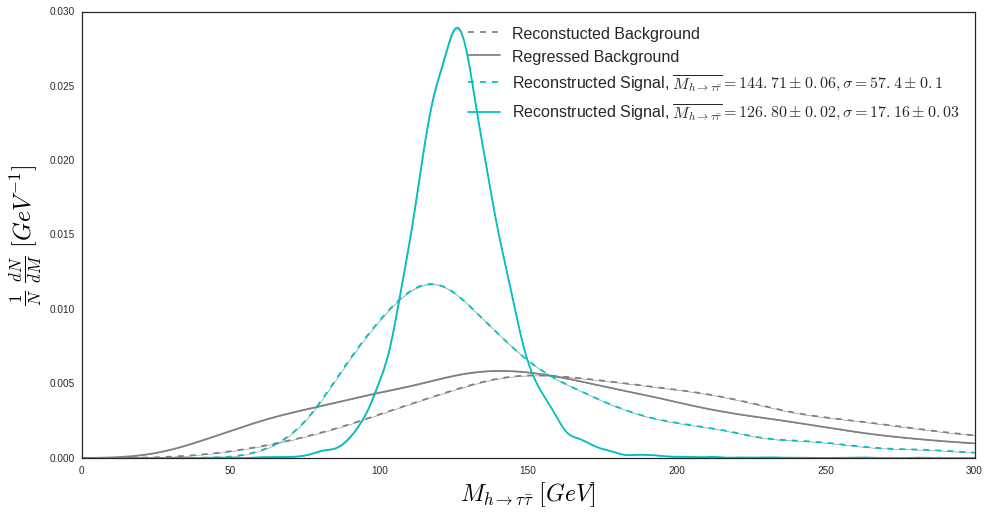

In [23]:
plt.figure(figsize=(16, 8))
sns.tsplot(data=plots['bkg' + '_kde'], time=xPlot, ci=[68, 95], color='grey', linestyle="dashed", condition="Reconstucted Background")
sns.tsplot(data=plots['bkg_reg' + '_kde'], time=xPlot, ci=[68, 95], color='grey', condition="Regressed Background")
sns.tsplot(data=plots['sig' + '_kde'], time=xPlot, ci=[68, 95], color='c', linestyle="dashed",
           condition=r'Reconstructed Signal, $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.1f}\pm{:.1f}$'.format(meanReco[0], meanReco[1], stdReco[0], stdReco[1]))
sns.tsplot(data=plots['sig_reg' + '_kde'], time=xPlot, ci=[68, 95], color='c',
           condition=r'Reconstructed Signal, $\overline{M_{h\rightarrow \tau\bar{\tau}}}' + r' = {:.2f}\pm{:.2f}, \sigma = {:.2f}\pm{:.2f}$'.format(meanReg[0], meanReg[1], stdReg[0], stdReg[1]))
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow \tau\bar{\tau}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### ROC Curve

In [34]:
print 'Reg:', roc_auc_score(valData.ix[sig|bkg, 'gen_target'], -np.abs(125-valData.ix[sig|bkg, 'reg_h_tt_mass']))
print 'Reco:', roc_auc_score(valData.ix[sig|bkg, 'gen_target'], -np.abs(125-valData.ix[sig|bkg, 'h_tt_mass']))

Reg: 0.866170661518
Reco: 0.720012344111


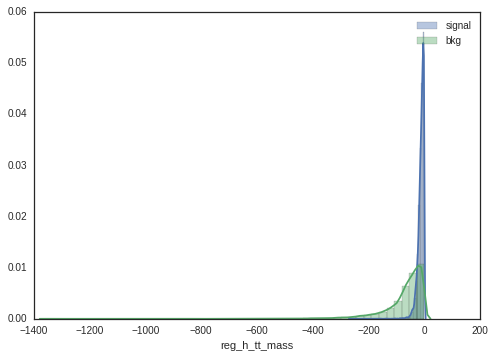

In [35]:
sns.distplot(-np.abs(125-valData.ix[sig, 'reg_h_tt_mass']), label='signal')
sns.distplot(-np.abs(125-valData.ix[bkg, 'reg_h_tt_mass']), label='bkg')
plt.legend()

## Classifier response

### Train

In [48]:
classFeatures = ['t_0_mass',
                 't_1_mass',
                 'b_0_mass', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_E', 'b_0_|p|',
                 'b_1_mass', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_E', 'b_1_|p|',
                 'mPT_px', 'mPT_py',
                 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_mass', 'h_bb_E', 'h_bb_|p|',
                 'diH_px', 'diH_py', 'diH_pz', 'diH_mass', 'diH_E', 'diH_|p|',
                 'hl_mT']

In [61]:
recoFeatures = ['h_tt_mass']
recoFeatures += ['t_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E',
                 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E',
                 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E']
recoFeatures += classFeatures
print len(recoFeatures), "Training features"
recoClass = XGBoostClassifier()
recoClass.fit(devData[recoFeatures], devData['gen_target'].values.astype('int'))

45 Training features


XGBoostClassifier(base_score=0.5, colsample=1.0, eta=0.3,
         features=['h_tt_mass', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 't_0_mass', 't_1_mass', 'b_0_mass', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_E', 'b_0_|p|', 'b_1_mass', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_E', 'b_1_|p|', 'mPT_px', 'mPT_py', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_mass', 'h_bb_E', 'h_bb_|p|', 'diH_px', 'diH_py', 'diH_pz', 'diH_mass', 'diH_E', 'diH_|p|', 'hl_mT'],
         gamma=None, max_depth=6, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=16, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=1.0, verbose=0)

In [62]:
regFeatures = ['reg_h_tt_mass']
regFeatures += ['reg_t_0_px', 'reg_t_0_py', 'reg_t_0_pz', 'reg_t_0_|p|', 'reg_t_0_E',
                'reg_t_1_px', 'reg_t_1_py', 'reg_t_1_pz', 'reg_t_1_|p|', 'reg_t_1_E',
                'reg_h_tt_px', 'reg_h_tt_py', 'reg_h_tt_pz', 'reg_h_tt_|p|', 'reg_h_tt_E']
regFeatures += classFeatures
print len(regFeatures), "Training features"
regClass = XGBoostClassifier()
regClass.fit(devData[regFeatures], devData['gen_target'].values.astype('int'))

45 Training features


XGBoostClassifier(base_score=0.5, colsample=1.0, eta=0.3,
         features=['reg_h_tt_mass', 'reg_t_0_px', 'reg_t_0_py', 'reg_t_0_pz', 'reg_t_0_|p|', 'reg_t_0_E', 'reg_t_1_px', 'reg_t_1_py', 'reg_t_1_pz', 'reg_t_1_|p|', 'reg_t_1_E', 'reg_h_tt_px', 'reg_h_tt_py', 'reg_h_tt_pz', 'reg_h_tt_|p|', 'reg_h_tt_E', 't_0_mass', 't_1_mass', 'b_0_mass', 'b_0_px', 'b_0_py', 'b..._mass', 'h_bb_E', 'h_bb_|p|', 'diH_px', 'diH_py', 'diH_pz', 'diH_mass', 'diH_E', 'diH_|p|', 'hl_mT'],
         gamma=None, max_depth=6, min_child_weight=1.0, missing=-999.0,
         n_estimators=100, nthreads=16, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=1.0, verbose=0)

### Test

In [63]:
recoPred = [recoClass.predict_proba(devData[recoFeatures])[:,1],
            recoClass.predict_proba(valData[recoFeatures])[:,1]]

In [64]:
regPred = [regClass.predict_proba(devData[regFeatures])[:,1],
           regClass.predict_proba(valData[regFeatures])[:,1]]

In [65]:
recoAUC = [roc_auc_score(devData['gen_target'].values, recoPred[0]),
           roc_auc_score(valData['gen_target'].values, recoPred[1])]
regAUC = [roc_auc_score(devData['gen_target'].values, regPred[0]),
          roc_auc_score(valData['gen_target'].values, regPred[1])]

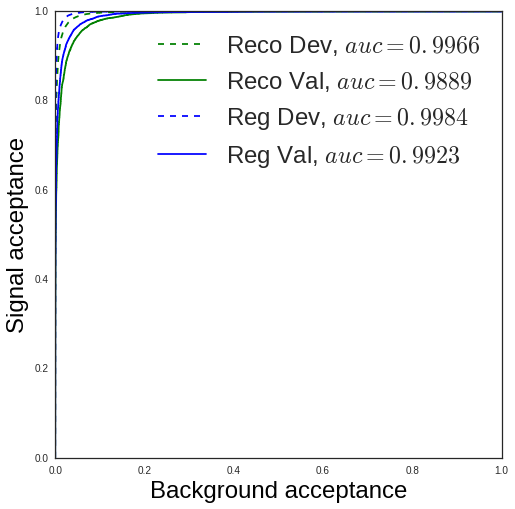

In [66]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(devData['gen_target'].values, recoPred[0])[:2],
         label=r'Reco Dev, $auc={:.4f}$'.format(recoAUC[0]), linestyle='dashed', color='g')
plt.plot(*roc_curve(valData['gen_target'].values, recoPred[1])[:2],
         label=r'Reco Val, $auc={:.4f}$'.format(recoAUC[1]), color='g')
plt.plot(*roc_curve(devData['gen_target'].values, regPred[0])[:2],
         label=r'Reg Dev, $auc={:.4f}$'.format(regAUC[0]), linestyle='dashed', color='b')
plt.plot(*roc_curve(valData['gen_target'].values, regPred[1])[:2],
         label=r'Reg Val, $auc={:.4f}$'.format(regAUC[1]), color='b')
#plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=24)
plt.show()